# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


кажется в столбце Tenure нас ожидают пропуски 

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

да, так и есть, плюс названия требуют переименования

In [5]:
data['Tenure'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

выбивающихся цифр нет. скорее всего пропуски означают 0 лет, тем более, что такое значение имеется

In [6]:
data[data['Tenure'].isna()].head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,83,15641732,Mills,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,86,15805254,Ndukaku,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,95,15676966,Capon,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,100,15633059,Fanucci,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,112,15665790,Rowntree,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


в целом, все остальные данные нормальные (во всяком случае, в первых 10 строчках с пропусками), так что просто заменим пропуски на 0

In [7]:
data[data['Tenure'] == 0].head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
29,30,15656300,Lucciano,411,France,Male,29,0.0,59697.17,2,1,1,53483.21,0
35,36,15794171,Lombardo,475,France,Female,45,0.0,134264.04,1,1,0,27822.99,1
57,58,15647091,Endrizzi,725,Germany,Male,19,0.0,75888.20,1,0,0,45613.75,0
72,73,15812518,Palermo,657,Spain,Female,37,0.0,163607.18,1,0,1,44203.55,0
127,128,15782688,Piccio,625,Germany,Male,56,0.0,148507.24,1,1,0,46824.08,1
149,150,15794413,Harris,416,France,Male,32,0.0,0.00,2,0,1,878.87,0
164,165,15658929,Taverner,683,Spain,Male,29,0.0,133702.89,1,1,0,55582.54,1
176,177,15645248,Ho,510,France,Female,30,0.0,0.00,2,1,1,130553.47,0
187,188,15708710,Ford,525,Spain,Female,37,0.0,0.00,1,0,1,131521.72,0
231,232,15627000,Freeman,610,France,Male,40,0.0,0.00,2,1,0,62232.60,0


сделал лишнюю проверку, посмотрел на строки с клиентами, которые меньше года. в целом, такие же, как и с пропусками. можно было бы, конечно, просто удалить, но люблю драться за каждый пропуск

In [8]:
data = data.fillna(0)
data.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

пропусков нет. быстро пробежимся по тем столбцам, где может быть что-то не то, а именно: Age и Gender

In [9]:
data['Age'].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       88, 92])

в целом, нормально - минимальный возраст 18, максимальный 92 (надеюсь, что он не ипотеку до сих пор выплачивает)

In [10]:
data['Gender'].unique()

array(['Female', 'Male'], dtype=object)

да, тоже всего два гендера, хотя в наших реалиях их могло бы быть и больше 40

In [11]:
data.duplicated().sum()

0

также глянем дубликаты в CustomerId

In [12]:
data['CustomerId'].duplicated().sum()

0

теперь можно и переименовывать

In [13]:
data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [14]:
data = data.rename(columns={'RowNumber':'Row_Number', 'CustomerId':'Customer_Id', 'CreditScore':'Credit_Score',
       'NumOfProducts':'Num_Of_Products', 'HasCrCard':'Has_Cr_Card',
       'IsActiveMember':'Is_Active_Member', 'EstimatedSalary':'Estimated_Salary'})

In [15]:
data.columns

Index(['Row_Number', 'Customer_Id', 'Surname', 'Credit_Score', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'Num_Of_Products', 'Has_Cr_Card',
       'Is_Active_Member', 'Estimated_Salary', 'Exited'],
      dtype='object')

In [16]:
data.drop(['Surname', 'Customer_Id', 'Row_Number'],axis=1,inplace =True)

удалили столбцы Surname, Customer_Id и Row_Number, поскольку они будут мешать применению методов

In [17]:
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.shape

(10000, 12)

Дабы не попасть в дамми-ловушку, преобразовали столбцы Geography и Gender техникой OHE

In [18]:
data_ohe.head()

,Credit_Score,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


###### Вывод

В исследуемом файле были обнаружены пропуски в столбце "Tenure", которые решено было заменить на нулевые значения. В остальных столбцах пропусков, равно, как и дубликатов обнаружено не было. Все столбцы имели соответствующий тип данных. Столбцы были переименованы в соттветствии с т.н. "змеиным регистром". Столбцы "Surname", "Customer_Id" и "Row_Number" были удалены, поскольку для конкрентной задачи они не требовались, но повлияли бы на исходные результаты. Другие нечисловые столбцы ("Geography" и "Gender") преобразовали техникой OHE. Таким образом, новый DataFrame полностью готов к дальнейшей работе 

## Исследование задачи

In [19]:
data_ohe_train, data_ohe_valid, data_ohe_test = np.split(data_ohe.sample(frac=1, random_state=12345), [int(.5*len(data_ohe)), int(.75*len(data_ohe))])
[len(data_ohe_train), len(data_ohe_valid), len(data_ohe_test)]

[5000, 2500, 2500]

Разбили данные на выборки. На обучающую - 50%, на валидационную - 25%, на тестовую - 25%

In [20]:
data_ohe_train.shape, data_ohe_valid.shape, data_ohe_test.shape

((5000, 12), (2500, 12), (2500, 12))

In [21]:
data_ohe_train.head()

,Credit_Score,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited,Geography_Germany,Geography_Spain,Gender_Male
7867,640,46,3.0,0.00,1,1,1,156260.08,0,0,1,0
1402,757,29,8.0,130306.49,1,1,0,77469.38,0,0,0,1
8606,807,42,5.0,0.00,2,1,1,74900.90,0,0,1,1
8885,668,45,4.0,102486.21,2,1,1,158379.25,0,0,1,1
6494,699,28,7.0,0.00,2,1,1,22684.78,0,0,0,1


проверили по длине и размеру. всё разбилось нацело

In [22]:
numeric = ['Credit_Score', 'Tenure', 'Age', 'Balance', 'Estimated_Salary']
scaler = StandardScaler()
features_train = data_ohe_train.drop(['Exited'], axis=1)
features_valid = data_ohe_valid.drop(['Exited'], axis=1)
features_test = data_ohe_test.drop(['Exited'], axis=1)
target_train = data_ohe_train['Exited']
target_valid = data_ohe_valid['Exited']
target_test = data_ohe_test['Exited']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

задали целевые признаки, подготовили данные и сразу же стандартизировали численные признаки

In [23]:
target_train.value_counts(normalize=True)

0    0.7958
1    0.2042
Name: Exited, dtype: float64

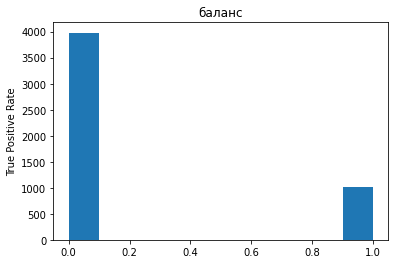

In [24]:
target_train.plot(kind='hist', )
plt.title('баланс')
plt.ylabel('True Positive Rate')

plt.show()

In [25]:
target_valid.value_counts(normalize=True)

0    0.8112
1    0.1888
Name: Exited, dtype: float64

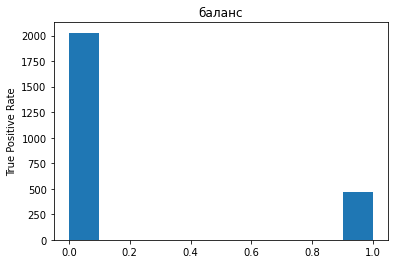

In [26]:
target_valid.plot(kind='hist', )
plt.title('баланс')
plt.ylabel('True Positive Rate')

plt.show()

In [27]:
target_test.value_counts(normalize=True)

0    0.7824
1    0.2176
Name: Exited, dtype: float64

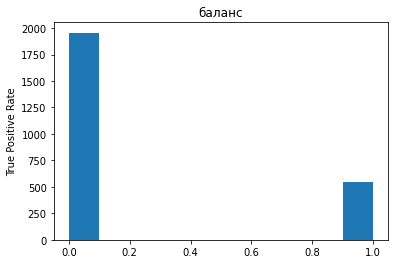

In [28]:
target_test.plot(kind='hist', )
plt.title('баланс')
plt.ylabel('True Positive Rate')

plt.show()

Баланс между положительными и отрицательными классами примерно 80:20, то есть, конечно же, классы не сбалансированы 

In [29]:
model_result = pd.DataFrame(columns=['model','F1', 'accuracy', 'auc_roc'])

сделаем DataFrame для сбора данных, чтобы всё было наглядно в конце, а сейчас пройдёмся по моделям

###### логиcтическая регрессия без учёта дисбаланса

In [30]:
model_logic = LogisticRegression(random_state=12345, solver='liblinear')
model_logic.fit(features_train, target_train)
predictions_logic = model_logic.predict(features_valid)
probabilities_valid = model_logic.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_logic)
accuracy = accuracy_score(target_valid, predictions_logic)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

for threshold in np.arange(0, 0.9, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
print()
print('F1: {:.3f}'.format(f1))
print('accuracy: {:.3f}'.format(accuracy))
print('auc_roc: {:.3f}'.format(auc_roc))
print()
print('баланс: ', pd.Series(predictions_logic).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_logic_without','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

Порог = 0.00 | Точность = 0.189, Полнота = 1.000
Порог = 0.02 | Точность = 0.189, Полнота = 0.998
Порог = 0.04 | Точность = 0.198, Полнота = 0.996
Порог = 0.06 | Точность = 0.215, Полнота = 0.985
Порог = 0.08 | Точность = 0.234, Полнота = 0.958
Порог = 0.10 | Точность = 0.252, Полнота = 0.930
Порог = 0.12 | Точность = 0.268, Полнота = 0.875
Порог = 0.14 | Точность = 0.298, Полнота = 0.852
Порог = 0.16 | Точность = 0.320, Полнота = 0.818
Порог = 0.18 | Точность = 0.347, Полнота = 0.782
Порог = 0.20 | Точность = 0.370, Полнота = 0.727
Порог = 0.22 | Точность = 0.389, Полнота = 0.663
Порог = 0.24 | Точность = 0.405, Полнота = 0.612
Порог = 0.26 | Точность = 0.438, Полнота = 0.587
Порог = 0.28 | Точность = 0.464, Полнота = 0.547
Порог = 0.30 | Точность = 0.477, Полнота = 0.494
Порог = 0.32 | Точность = 0.502, Полнота = 0.462
Порог = 0.34 | Точность = 0.530, Полнота = 0.430
Порог = 0.36 | Точность = 0.525, Полнота = 0.379
Порог = 0.38 | Точность = 0.549, Полнота = 0.356
Порог = 0.40 | Точно

###### дерево решений без учёта дисбаланса

In [31]:
model_tree = DecisionTreeClassifier(random_state=12345)
model_tree.fit(features_train, target_train)
predictions_tree = model_tree.predict(features_valid)
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_tree)
accuracy = accuracy_score(target_valid, predictions_tree)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

for threshold in np.arange(0, 1, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
    
print()
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ', pd.Series(predictions_logic).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_tree_without','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

Порог = 0.00 | Точность = 0.458, Полнота = 0.498
Порог = 0.02 | Точность = 0.458, Полнота = 0.498
Порог = 0.04 | Точность = 0.458, Полнота = 0.498
Порог = 0.06 | Точность = 0.458, Полнота = 0.498
Порог = 0.08 | Точность = 0.458, Полнота = 0.498
Порог = 0.10 | Точность = 0.458, Полнота = 0.498
Порог = 0.12 | Точность = 0.458, Полнота = 0.498
Порог = 0.14 | Точность = 0.458, Полнота = 0.498
Порог = 0.16 | Точность = 0.458, Полнота = 0.498
Порог = 0.18 | Точность = 0.458, Полнота = 0.498
Порог = 0.20 | Точность = 0.458, Полнота = 0.498
Порог = 0.22 | Точность = 0.458, Полнота = 0.498
Порог = 0.24 | Точность = 0.458, Полнота = 0.498
Порог = 0.26 | Точность = 0.458, Полнота = 0.498
Порог = 0.28 | Точность = 0.458, Полнота = 0.498
Порог = 0.30 | Точность = 0.458, Полнота = 0.498
Порог = 0.32 | Точность = 0.458, Полнота = 0.498
Порог = 0.34 | Точность = 0.458, Полнота = 0.498
Порог = 0.36 | Точность = 0.458, Полнота = 0.498
Порог = 0.38 | Точность = 0.458, Полнота = 0.498
Порог = 0.40 | Точно

###### случайный лес без учёта дисбаланса

In [32]:
model_forest = RandomForestClassifier(random_state = 12345)
model_forest.fit(features_train, target_train)
predictions_forest = model_forest.predict(features_valid)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_forest)
accuracy = accuracy_score(target_valid, predictions_forest)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

for threshold in np.arange(0, 0.98, 0.02):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid) 
    recall = recall_score(target_valid, predicted_valid) 

    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
print()
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ', pd.Series(predictions_logic).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_forest_without','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

Порог = 0.00 | Точность = 0.197, Полнота = 0.996
Порог = 0.02 | Точность = 0.226, Полнота = 0.989
Порог = 0.04 | Точность = 0.251, Полнота = 0.970
Порог = 0.06 | Точность = 0.279, Полнота = 0.956
Порог = 0.08 | Точность = 0.304, Полнота = 0.932
Порог = 0.10 | Точность = 0.325, Полнота = 0.898
Порог = 0.12 | Точность = 0.349, Полнота = 0.871
Порог = 0.14 | Точность = 0.365, Полнота = 0.845
Порог = 0.16 | Точность = 0.382, Полнота = 0.816
Порог = 0.18 | Точность = 0.397, Полнота = 0.778
Порог = 0.20 | Точность = 0.420, Полнота = 0.754
Порог = 0.22 | Точность = 0.437, Полнота = 0.731
Порог = 0.24 | Точность = 0.455, Полнота = 0.701
Порог = 0.26 | Точность = 0.477, Полнота = 0.678
Порог = 0.28 | Точность = 0.507, Полнота = 0.665
Порог = 0.30 | Точность = 0.528, Полнота = 0.644
Порог = 0.32 | Точность = 0.554, Полнота = 0.629
Порог = 0.34 | Точность = 0.570, Полнота = 0.606
Порог = 0.36 | Точность = 0.601, Полнота = 0.585
Порог = 0.38 | Точность = 0.624, Полнота = 0.561
Порог = 0.40 | Точно

###### Вывод

Без учёта дисбаланса самое большое значение F1-меры оказалось у модели Случайного леса (0.576), кстати, она же оказалась и самой точной (0.871) и с самым большим значением AUC-ROC (0.853). Вероятнее всего, именно с данной моделью мы и будем работать в дальнейшем. Баланс на всех трёх представленных моделях оказался примерно одинаковым - 94:6 отрицательные:положительные ответы

## Борьба с дисбалансом

###### взвешивание классов Логистическая регрессия

In [33]:
model_logic = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_logic.fit(features_train, target_train)
predictions_logic = model_logic.predict(features_valid)
probabilities_valid = model_logic.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]   
f1 = f1_score(target_valid, predictions_logic)
accuracy = accuracy_score(target_valid, predictions_logic)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_logic).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_logic_balanced','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.502
accuracy: 0.734
auc_roc: 0.788

баланс:  
 0    0.6548
1    0.3452
dtype: float64


После "взвешивания классов" значение F1-меры увеличилось до 0.47 в модели Логической регрессии, правда, качество чуть снизилось до 0.715

###### увеличение выборки (upsampling ) Логистическая регрессия

In [34]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model_logic = LogisticRegression(random_state=12345, solver='liblinear')
model_logic.fit(features_upsampled, target_upsampled)
predictions_logic = model_logic.predict(features_valid)
probabilities_valid = model_logic.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_logic)
accuracy = accuracy_score(predictions_logic,target_valid)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_logic).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_logic_upsample','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.505
accuracy: 0.73
auc_roc: 0.788

баланс:  
 0    0.6436
1    0.3564
dtype: float64


###### уменьшение выборки (downsample) Логистическая регрессия

In [35]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.12)

model_logic = LogisticRegression(random_state=12345, solver='liblinear')
model_logic.fit(features_downsampled, target_downsampled)
predictions_logic = model_logic.predict(features_valid)
probabilities_valid = model_logic.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_logic)
accuracy = accuracy_score(target_valid, predictions_logic)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_logic).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_logic_downsample','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.41
accuracy: 0.513
auc_roc: 0.777

баланс:  
 1    0.6376
0    0.3624
dtype: float64


###### взвешивание класов в модели Дерево решений

In [36]:
model_tree = DecisionTreeClassifier(random_state = 12345, class_weight='balanced')
model_tree.fit(features_train, target_train)
predictions_tree = model_tree.predict(features_valid)
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_tree)
accuracy = accuracy_score(target_valid, predictions_tree)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_tree).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_tree_balanced','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.463
accuracy: 0.789
auc_roc: 0.671

баланс:  
 0    0.7964
1    0.2036
dtype: float64


###### взвешивание классов в модели Случайный лес

In [37]:
model_forest = RandomForestClassifier(random_state = 12345, class_weight='balanced')
model_forest.fit(features_train, target_train)
predictions_forest = model_forest.predict(features_valid)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_forest)
accuracy = accuracy_score(target_valid, predictions_forest)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
          
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_forest).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_forest_balanced','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.568
accuracy: 0.871
auc_roc: 0.847

баланс:  
 0    0.89
1    0.11
dtype: float64


###### увеличение выборки Дерево решений

In [38]:
model_tree = DecisionTreeClassifier(random_state = 12345)
model_tree.fit(features_upsampled, target_upsampled)
predictions_tree = model_tree.predict(features_valid)
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_tree)
accuracy = accuracy_score(target_valid, predictions_tree)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_tree).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_tree_upsample','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.451
accuracy: 0.788
auc_roc: 0.663

баланс:  
 0    0.802
1    0.198
dtype: float64


###### увеличение выборки Случайный лес

In [39]:
model_forest = RandomForestClassifier(random_state = 12345)
model_forest.fit(features_upsampled, target_upsampled)
predictions_forest = model_forest.predict(features_valid)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_forest)
accuracy = accuracy_score(target_valid, predictions_forest)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
          
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_forest).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_forest_upsample','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)


F1: 0.588
accuracy: 0.853
auc_roc: 0.846

баланс:  
 0    0.8324
1    0.1676
dtype: float64


###### уменьшение выборки Дерево решений

In [40]:
model_tree = DecisionTreeClassifier(random_state = 12345)
model_tree.fit(features_downsampled, target_downsampled)
predictions_tree = model_tree.predict(features_valid)
probabilities_valid = model_tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_tree)
accuracy = accuracy_score(target_valid, predictions_tree)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_tree).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_tree_downsample','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.429
accuracy: 0.615
auc_roc: 0.673

баланс:  
 0    0.5152
1    0.4848
dtype: float64


###### уменьшение выборки Случайный лес

In [41]:
model_forest = RandomForestClassifier(random_state = 12345)
model_forest.fit(features_downsampled, target_downsampled)
predictions_forest = model_forest.predict(features_valid)
probabilities_valid = model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predictions_forest)
accuracy = accuracy_score(target_valid, predictions_forest)   
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
          
print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_forest).value_counts(normalize=True))
new_row = pd.Series(data={'model': 'model_tree_downsample','F1': f1, 'accuracy':accuracy, 'auc_roc':auc_roc}) 
model_result = model_result.append(new_row,ignore_index=True)

F1: 0.465
accuracy: 0.614
auc_roc: 0.839

баланс:  
 1    0.5328
0    0.4672
dtype: float64


In [42]:
model_result.sort_values(by = 'F1',ascending=False).head()

,model,F1,accuracy,auc_roc
9,model_forest_upsample,0.588103,0.8532,0.846281
2,model_forest_without,0.575558,0.8708,0.852579
7,model_forest_balanced,0.567604,0.8708,0.847386
4,model_logic_upsample,0.504769,0.7300,0.788136
3,model_logic_balanced,0.501873,0.7340,0.788124
1,model_tree_without,0.477157,0.7940,0.680400
11,model_tree_downsample,0.464523,0.6136,0.838542
6,model_tree_balanced,0.462793,0.7892,0.670939
8,model_tree_upsample,0.450879,0.7876,0.662638
10,model_tree_downsample,0.428741,0.6152,0.672603


Как видим из таблицы, наилучшие значения F1-меры оказались у модели Случайного леса, худшее - у модели логистической регрессии. При этом, значение F1-меры после 'борьбы с дисбалансом' увеличилось (с 0.576 до 0.588). Наилучшие значение показала техника увеличения выборки (upsampling). Теперь используя её подберём оптимальные гиперпараметры 

In [43]:
%%time
df_result = pd.DataFrame(columns=['depth', 'n_est', 'f1', 'accuracy', 'auc_roc'])

for n_est in range(210, 230):
    for depth in range (15, 20):
        model_forest = RandomForestClassifier(n_estimators = n_est, max_depth = depth, random_state=12345)
        model_forest.fit(features_upsampled, target_upsampled)
        predictions_forest = model_forest.predict(features_valid)
        probabilities_valid = model_forest.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        f1 = f1_score(target_valid, predictions_forest)
        accuracy = accuracy_score(target_valid, predictions_forest)   
        auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
        
        new_row = pd.Series(data={'depth': depth, 'n_est': n_est, 'f1': f1, 'accuracy': accuracy, 'auc_roc': auc_roc})
        df_result = df_result.append(new_row,ignore_index=True)


CPU times: user 2min 48s, sys: 694 ms, total: 2min 49s
Wall time: 2min 50s


In [44]:
df_result.sort_values(by = 'f1',ascending=False).head(10)

,depth,n_est,f1,accuracy,auc_roc
89,19.0,227.0,0.605322,0.8576,0.848183
84,19.0,226.0,0.605117,0.8580,0.848353
94,19.0,228.0,0.604444,0.8576,0.848194
99,19.0,229.0,0.603774,0.8572,0.848079
44,19.0,218.0,0.603774,0.8572,0.848497
9,19.0,211.0,0.603104,0.8568,0.847725
19,19.0,213.0,0.603104,0.8568,0.847956
54,19.0,220.0,0.603104,0.8568,0.848563
24,19.0,214.0,0.603104,0.8568,0.848166
79,19.0,225.0,0.603104,0.8568,0.848343


Как видим, максимальное значение F1-меры (0.605) получается при при глубине, равной 19 и при числе "деревьев" равных 227. (Параметры перебирались долго, просто дабы не загружать код, оставил только те отрезки, где уже обнаружились максимальные параметры). Теперь проверим на тестовой выборке

###### Тестирование модели 

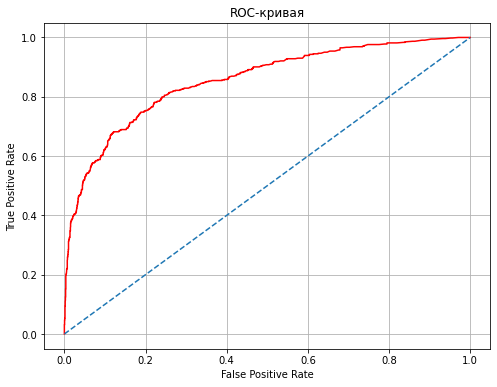

F1: 0.628
accuracy: 0.851
auc_roc: 0.854

баланс:  
 0    0.8176
1    0.1824
dtype: float64


In [45]:
model_forest_test = RandomForestClassifier(n_estimators = 227, max_depth = 19, random_state=12345)
model_forest_test.fit(features_upsampled, target_upsampled)
predictions_forest_test = model_forest_test.predict(features_test)
probabilities_valid = model_forest_test.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_test, predictions_forest_test)
accuracy = accuracy_score(target_test, predictions_forest_test)   
auc_roc = roc_auc_score(target_test, probabilities_one_valid)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)
plt.show()

print('F1:', round(f1, 3))
print('accuracy:', round(accuracy, 3))
print('auc_roc:', round(auc_roc, 3))
print()
print('баланс: ','\n', pd.Series(predictions_forest_test).value_counts(normalize=True))

Подсчитали следующие показатели на тестовой модели: значение F1-меры, качество модели, построили график зависимости TPR от FPR (ROC-кривую), вычислили площадь под кривой (AUC-ROC),  изучен баланс.

Как видим, значение F1-меры увеличилось с 0.605 до 0.628, При этом, качество чуть снизилось (0.851 против 0.858), но увеличилось значение AUC-ROC (0.854 против 0.848). Чтобы оценить качество тестовой модели проверим её на адекватность и подсчитаем качество константной модели

###### Качество константной модели 

In [46]:
target_pred_constant = pd.Series(0, index=target_test.index)
print(round(accuracy_score(target_valid, target_pred_constant), 3))

0.811


Качество константной можели оказалось ниже тестируемой (0.811 простов 0.851), а значит нашу модель можно считать адекватной

# Вывод

В ходе работы было выполнено:

- Открыт файл и изучен, проверена его целостность, выбиающиеся значения, пропуски
- Найдены и обработаны пропуски в столбце 'Tenure'
- Переименованы столбцы
- Удалены лишние столбцы, а именно: 'Surname', 'Customer_Id', 'Row_Number'
- Преобразованы столбцы Geography и Gender техникой OHE
- Данные были разбиты на выборки: На обучающую - 50%, на валидационную - 25%, на тестовую - 25%
- Заданы целевые признаки, подготовка данных 
- Стандартизированы признаки 
- Изучен баланс между положительными и отрицательными классами
- Исследованы следующие модели без учёта дисбаланса: логистическая регрессия, дерево решений, случайный лес
- В качестве борьбы с дисбалансом применялись следующие методы: взвешивание классов, увеличение выборки, уменьшение выборки
- Подсчитаны значения F1-меры, качества модели, AUC-ROC
- Отобрана наилучшая модель и наилучший метод борьбы с дисбалансом по максимальному значению F1-меры
- Подобраны оптимальные гиперпараметры
- Гиперпараметры проверены на тестовой модели
- У тестовой модели подсчитано значение F1-меры, оценено качество модели, построен график зависимости TPR от FPR (ROC-кривую), вычислена площадь под кривой (AUC-ROC), изучен баланс 
- Тестовая модель сравнивалась с константной моделью

По результатам выбора модели лучшей оказалась **модель Случайный лес** в ней значение **F1-меры** получилось **0.576** без учёта дисбаланса. Лучшей "борьбой с дисбалансом" оказался метод **увеличение выборки**, при его использовании значение **F1-меры** увеличилось до **0.588**. Максимальный показатель значения F1-меры оказалсь при следующих гиперпараметрах: **глубина - 19, количество деревьев - 227**. При этих гиперпараметрах были определены показатели **тестовой модели**: значение **F1-меры = 0.628**, **качество 0.851**, **AUC-ROC = 0.854**. **Качество константной** модели равно **0.811**, что говорит о том, что нашу тестовую модель можно считать адекватной и применимой